In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy.stats import percentileofscore
from pathlib import Path
from time import sleep

### Data Storytelling
 - **[Dataset](#Dataset-Collection)**
   - nfl draft, single source
 - **Audience**
   - semi-technical, briefing for analysts discussing draft trends over history. do past results provide as reasonable expectations as individual player projections?
 - **[Exploration](#Exploration)**
   - initial looks
   - focus on QB position, others may be harder to corral and compare
     - popular position for top picks this year
   - what metrics can measure performance?
     - AV, AV/G
     - passing yds, games playhed, years starter?
  - **[Narrative](#Build-Narrative)**
    - defined performance as a roughly modified AV/G. career performance metric divided by games played `mAV`
      - *great QBs with long careers undervalued*
    - considered various "tiers" of QBs defined by metric percentile
    - determined performance history at various pick ranges
      - historically, have higher picks necessarily led to better quarterbacks?
        - pick 1 clearly best, not huge difference between pick 2, 3, 4, 5, picks 6-10, or picks 10-16
    - other factors from data that correlate to performance?
      - better QBs typically drafted at younger ages. Drafting younger QBs is a relatively recent trend.
      - no clear trends when looking at college only (AKA `Uni` AKA university)
      - interestingly, most NFL franchises have drafted a similar amount of QBs since 1990
        - my expectation was that teams with better success at drafting QBs would have drafted less over time
  - *[Other](https://github.com/NBPub/nfl_draft_vs_market)*
    - add in more data sources to extend analysis. linked example takes into account the rookie salary limits, expected performance of a draft pick, and expected veteran cost for similar performance to define "surplus value" that can be captured in the draft.
    - player measurables would also be useful to add to find possible predictors of performance.

#### Dataset Collection
 - HTML tables from `pro-football-reference.com/`
 - minimal cleaning

In [3]:
class DraftTable:
    def __init__(self, year):
        self.year = year
        self.table = None
    
    def data_import(self):
        URL = f"https://www.pro-football-reference.com/years/{self.year}/draft.htm"
        data = pd.read_html(URL)[0]
        
        # clean column names, drop extras
        rename = []
        for c_name in data.columns:
            if c_name[0].startswith('Unnamed:'):
                rename.append(c_name[1])
            else:
                rename.append(f"{c_name[0]}_{c_name[1]}")
        data.columns = rename
        data.rename(columns={'St':'Yrs_Starter', 'Solo':'Tackles_Solo', 'College/Univ':'Uni'}, inplace=True)
        data.drop(data.columns[-1], inplace=True, axis=1)
        data.fillna(0, inplace=True)
        data = data[data.Pos!='Pos']
        data.loc[:,'draft_year'] = self.year
        self.table = data
        
    def save(self, folder):
        if type(self.table) == type(None):
            return
        p = Path(folder, f'draft_{self.year}.csv')
        self.table.to_csv(p)
    
    def dtypes_opt(self):
        if type(self.table) == type(None):
            return
        # ignore warning for this
        pd.options.mode.chained_assignment = None
        
        # object --> string
        str_cols = ['Tm','Player','Pos','Uni']
        self.table[str_cols] = self.table[str_cols].astype('string')
        # sack --> float
        self.table['Sk'] = self.table['Sk'].astype(float)
        # rest --> int
        int_cols = self.table.columns[~self.table.columns.isin(str_cols + ['Sk'])]
        self.table[int_cols] = self.table[int_cols].astype(int)

        # restore warning
        pd.options.mode.chained_assignment = 'warn'

In [6]:
df = pd.DataFrame()

for year in range(1990,2024):
    t = DraftTable(year)
    t.data_import()
    df = pd.concat([df, t.table])
    # t.save(Path('draft_tables'))
    sleep(1)
    print(year, 'completed')
    
df.reset_index(drop=True,inplace=True)
df.head()

1990 completed
1991 completed
1992 completed
1993 completed
1994 completed
1995 completed
1996 completed
1997 completed
1998 completed
1999 completed
2000 completed
2001 completed
2002 completed
2003 completed
2004 completed
2005 completed
2006 completed
2007 completed
2008 completed
2009 completed
2010 completed
2011 completed
2012 completed
2013 completed
2014 completed
2015 completed
2016 completed
2017 completed
2018 completed
2019 completed
2020 completed
2021 completed
2022 completed
2023 completed


,Rnd,Pick,Tm,Player,Pos,Age,To,Misc_AP1,Misc_PB,Yrs_Starter,...,Rushing_Yds,Rushing_TD,Receiving_Rec,Receiving_Yds,Receiving_TD,Int,Sk,Uni,draft_year,Tackles_Solo
0,1,1,IND,Jeff George,QB,22,2001,0,0,9,...,307,2,0,0,0,0,0,Illinois,1990,NaN
1,1,2,NYJ,Blair Thomas,RB,22,1995,0,0,3,...,2236,7,71,513,2,0,0,Penn St.,1990,NaN
2,1,3,SEA,Cortez Kennedy HOF,DT,22,2000,3,8,9,...,0,0,0,0,0,3,58.0,Miami (FL),1990,NaN
3,1,4,TAM,Keith McCants,DE,22,1995,0,0,2,...,0,0,0,0,0,1,13.5,Alabama,1990,NaN
4,1,5,SDG,Junior Seau HOF,LB,21,2009,6,12,16,...,0,0,2,8,0,18,56.5,USC,1990,NaN


In [10]:
# ignore warning for this
pd.options.mode.chained_assignment = None
df.drop(columns='Tackles_Solo', inplace=True)

# object --> string
str_cols = ['Tm','Player','Pos','Uni']
df[str_cols] = df[str_cols].astype('string')
# sack --> float
df['Sk'] = df['Sk'].astype(float)
# rest --> int
int_cols = df.columns[~df.columns.isin(str_cols + ['Sk'])]
df[int_cols] = df[int_cols].astype(int)

# restore warning
pd.options.mode.chained_assignment = 'warn'

In [41]:
pd.options.mode.chained_assignment = None
df.drop(columns = ['Receiving_Rec', 'Receiving_Yds', 'Receiving_TD', 'Sk', 'Int', 'Approx Val_DrAV',], inplace=True)
df.rename(columns = {'Misc_AP1':'AP1', 'Misc_PB':'PB', 'Approx Val_wAV':'wAV',
                     }, inplace=True)
pass_rename = {col:col.replace('Passing_','') for col in df.columns[df.columns.str.startswith('Passing')]}
df.rename(columns = pass_rename, inplace=True)
pd.options.mode.chained_assignment = 'warn'

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8814 entries, 0 to 8813
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rnd          8814 non-null   int64 
 1   Pick         8814 non-null   int64 
 2   Tm           8814 non-null   object
 3   Player       8814 non-null   object
 4   Pos          8814 non-null   object
 5   Age          8814 non-null   int64 
 6   To           8814 non-null   int64 
 7   AP1          8814 non-null   int64 
 8   PB           8814 non-null   int64 
 9   Yrs_Starter  8814 non-null   int64 
 10  wAV          8814 non-null   int64 
 11  G            8814 non-null   int64 
 12  Cmp          8814 non-null   int64 
 13  Att          8814 non-null   int64 
 14  Yds          8814 non-null   int64 
 15  TD           8814 non-null   int64 
 16  Int          8814 non-null   int64 
 17  Rushing_Att  8814 non-null   int64 
 18  Rushing_Yds  8814 non-null   int64 
 19  Rushing_TD   8814 non-null   int

In [43]:
df.to_csv(Path('nfl_draft_table.csv'))

#### Exploration
 - 8814 draft picks from 1990-2023
 - 418 quarterbacks
 - add/modify performance metric

In [231]:
df = pd.read_csv(Path('nfl_draft_table.csv'), index_col=0)

In [37]:
df.shape[0], df[df.Pos == 'QB'].shape[0]

(8814, 418)

In [232]:
df = df[df.Pos == 'QB']

In [45]:
df.sample(3).T

,8558,1001,614
Rnd,1,1,11
Pick,4,1,284
Tm,IND,NWE,DEN
Player,Anthony Richardson,Drew Bledsoe,Shawn Moore
Pos,QB,QB,QB
Age,21,21,23
To,2023,2006,1992
AP1,0,0,0
PB,0,4,0
Yrs_Starter,0,12,0


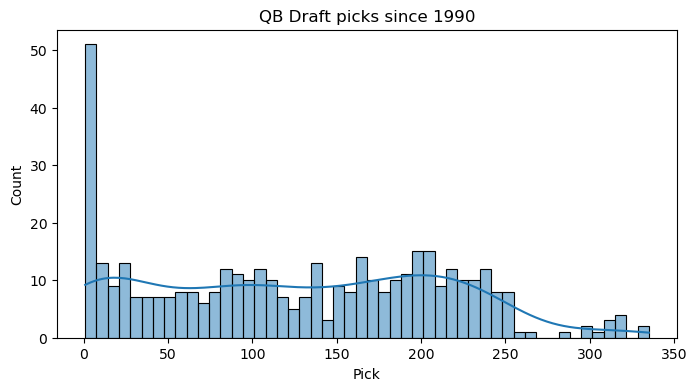

In [52]:
plt.figure(figsize=(8,4))
sns.histplot(df.Pick, kde=True, bins=50)
plt.title("QB Draft picks since 1990")
plt.show()

[PFR's Approximate Value metric](https://www.pro-football-reference.com/about/approximate_value.htm)

KDE shows a few distinct "humps" or tiers.

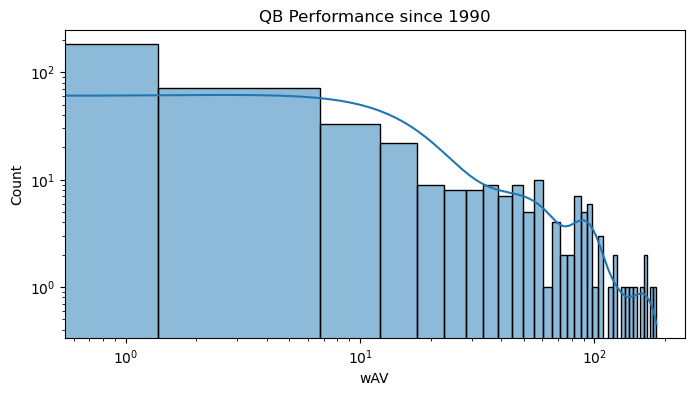

In [233]:
plt.figure(figsize=(8,4))
sns.histplot(df.wAV, kde=True)
plt.title("QB Performance since 1990")
plt.xscale('log')
plt.yscale('log')
plt.show()

*games played sometimes used as metric, check for zeros*

In [71]:
df.G.describe()

count    418.000000
mean      38.574163
std       56.956296
min        0.000000
25%        1.000000
50%       14.500000
75%       53.750000
max      335.000000
Name: G, dtype: float64

<Axes: xlabel='G'>

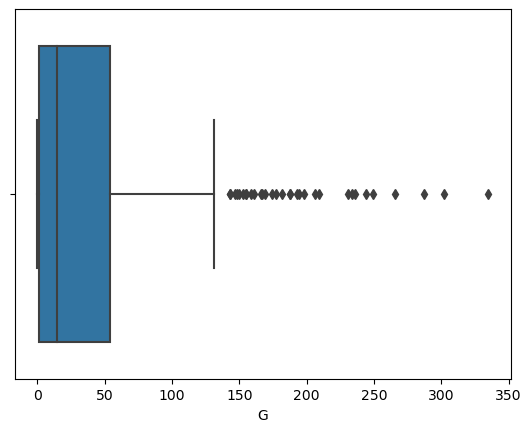

In [70]:
sns.boxplot(x=df.G)

**Performance Tiers** | *defined by modified `wAV` percentile*

 - wAV measures overall career and will not allow for recent players, normalize wAV by games played `G`
 - raw normalization favors recent QBs who start strong, as they have not yet had to maintain consistent high performance
   - ex: Stroud/Purdy vs Mahomes 
 - added modification factors: `wAV**X` and `G+1+Y`. earlier draft years are likely overvalued now
   - `X=1.5`, `Y=1`
   - no QBs drafted after 2020 are in the top tiers. instead of trying to fudge factors more, I will justify by stating that at least 3 years of play is needed to compare performance against the population

In [133]:
df = pd.read_csv(Path('nfl_draft_table.csv'), index_col=0)
df = df[df.Pos == 'QB']

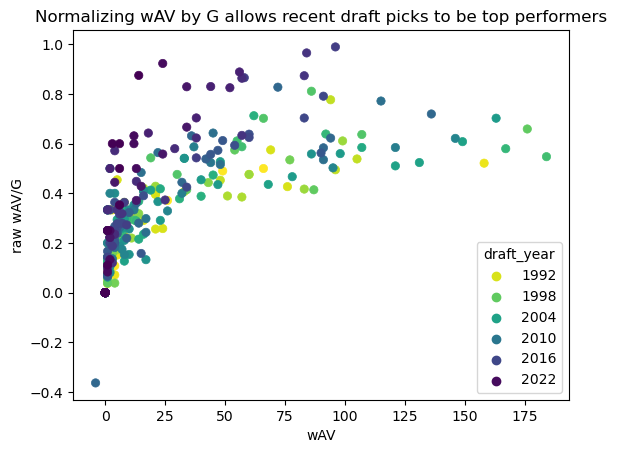

In [134]:
sns.scatterplot(df, y=df.wAV/(df.G+1), x='wAV', hue='draft_year', edgecolor='face', palette='viridis_r')
plt.ylabel('raw wAV/G')
plt.title('Normalizing wAV by G allows recent draft picks to be top performers')
plt.show()

In [135]:
df['mAV'] = (df.wAV**(1.2))/((df.G+2))
print('dropping', df[df.mAV.isna()].Player)
df.drop(index=df[df.mAV.isna()].index, inplace=True)

dropping 5928    Ryan Lindley
Name: Player, dtype: object


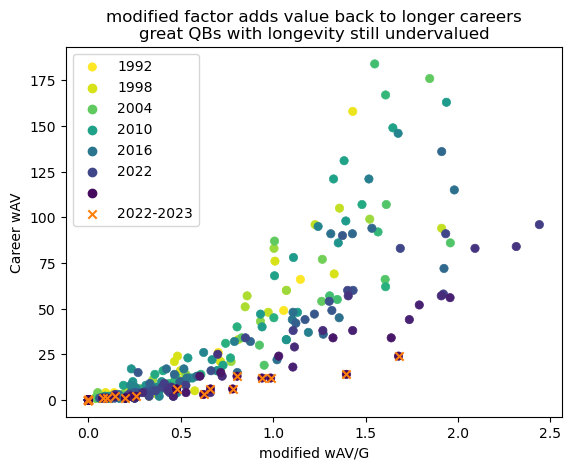

In [170]:
sns.scatterplot(df, x='mAV', y='wAV', hue='draft_year', edgecolor='face', palette='viridis_r')
plt.scatter(data=df[df.draft_year.between(2022,2023)], x='mAV', y='wAV', marker='x')

leg = plt.legend()
mylabels = [l._text for l in leg.texts[:-1]]
mylabels.append('')
mylabels.append('2022-2023')
plt.legend(loc='upper left', labels=mylabels)

plt.xlabel('modified wAV/G')
plt.ylabel('Career wAV')
plt.title('modified factor adds value back to longer careers\n\
great QBs with longevity still undervalued')
#plt.suptitle('', y=.85)
plt.show()


In [140]:
df.to_csv('nfl_draft_QBs_modified_wAV.csv')

*determine percentile cutoffs*

In [141]:
cutoffs = np.percentile(df.mAV, [90, 95, 98, 99])

In [142]:
cutoffs

array([1.35777099, 1.61738569, 1.92348465, 1.95864348])

*sanity check, scrollable for notebook views. commenting out for online viewing*

*can also check picks from last two years*

In [143]:
df[['Pick','Player','Yrs_Starter','draft_year','wAV','G','mAV']].sort_values('mAV', ascending=False).head(50)

,Pick,Player,Yrs_Starter,draft_year,wAV,G,mAV
7025,10,Patrick Mahomes,5,2017,96,96,2.440616
7300,32,Lamar Jackson,4,2018,84,86,2.315541
7275,7,Josh Allen,5,2018,83,94,2.092293
5490,1,Cam Newton,9,2011,115,148,1.980369
2441,11,Daunte Culpepper,5,1999,86,105,1.958909
7831,53,Jalen Hurts,2,2020,56,62,1.957247
3985,24,Aaron Rodgers,14,2005,163,231,1.937623
6897,135,Dak Prescott,6,2016,91,114,1.933712
5744,1,Andrew Luck,5,2012,72,86,1.924493
7027,12,Deshaun Watson,3,2017,58,66,1.921342


In [148]:
df[df.draft_year.between(2022,2023)].sort_values('mAV', ascending=False).head(10)

,Pick,Player,Yrs_Starter,draft_year,wAV,G,mAV
8554,262,Brock Purdy,0,2022,24,25,1.678378
8556,2,C.J. Stroud,0,2023,14,15,1.396062
8436,144,Sam Howell,0,2022,12,18,0.986251
8366,74,Desmond Ridder,0,2022,12,19,0.939287
8312,20,Kenny Pickett,1,2022,13,25,0.804208
8587,33,Will Levis,0,2023,6,9,0.780529
8689,135,Aidan O'Connell,0,2023,6,11,0.660447
8558,4,Anthony Richardson,0,2023,3,4,0.622865
8555,1,Bryce Young,0,2023,6,16,0.476990
8539,247,Skylar Thompson,0,2022,2,7,0.255266


---

**Tier I, 99th percentile**
 - 5 QBs, all first round picks

In [152]:
df[df.mAV>= cutoffs[-1]].sort_values('mAV', ascending=False)[['Pick','Player','Yrs_Starter','draft_year',
                                                              'AP1','PB','Att','Yds','TD','Int','Rushing_Yds',
                                                              'wAV','G','mAV']]

,Pick,Player,Yrs_Starter,draft_year,AP1,PB,Att,Yds,TD,Int,Rushing_Yds,wAV,G,mAV
7025,10,Patrick Mahomes,5,2017,2,6,3590,28424,219,63,1936,96,96,2.440616
7300,32,Lamar Jackson,4,2018,2,3,2112,15887,125,45,5258,84,86,2.315541
7275,7,Josh Allen,5,2018,0,3,3145,22703,167,78,3611,83,94,2.092293
5490,1,Cam Newton,9,2011,1,3,4474,32382,194,123,5628,115,148,1.980369
2441,11,Daunte Culpepper,5,1999,0,3,3199,24153,149,106,2652,86,105,1.958909


**Tier II, 98th percentile**
 - 4 QBs, later picks included

In [171]:
df[df.mAV.between(cutoffs[-2],cutoffs[-1])].sort_values('mAV', ascending=False)[['Pick','Player','Yrs_Starter','draft_year',
                                                              'AP1','PB','Att','Yds','TD','Int','Rushing_Yds',
                                                              'wAV','G','mAV']]

,Pick,Player,Yrs_Starter,draft_year,AP1,PB,Att,Yds,TD,Int,Rushing_Yds,wAV,G,mAV
7831,53,Jalen Hurts,2,2020,0,2,1578,11764,67,34,2503,56,62,1.957247
3985,24,Aaron Rodgers,14,2005,4,10,7661,59055,475,105,3466,163,231,1.937623
6897,135,Dak Prescott,6,2016,0,4,3873,29459,202,74,1884,91,114,1.933712
5744,1,Andrew Luck,5,2012,0,4,3290,23671,171,83,1590,72,86,1.924493


**Tier III, 95th percentile**
 - 12 QBs, first round heavily favored
 - "unicorns" show up: Trent Green, Brock Purdy. Tom Brady in the following tier?

In [172]:
df[df.mAV.between(cutoffs[-3],cutoffs[-2])].sort_values('mAV', ascending=False)[['Pick','Player','Yrs_Starter','draft_year',
                                                              'AP1','PB','Att','Yds','TD','Int','Rushing_Yds',
                                                              'wAV','G','mAV']]

,Pick,Player,Yrs_Starter,draft_year,AP1,PB,Att,Yds,TD,Int,Rushing_Yds,wAV,G,mAV
7027,12,Deshaun Watson,3,2017,0,3,2089,16756,118,45,1994,58,66,1.921342
5818,75,Russell Wilson,11,2012,0,9,5665,43653,334,106,5307,136,188,1.912023
1222,222,Trent Green,7,1993,0,2,3740,28475,162,114,914,94,120,1.911585
7525,1,Kyler Murray,4,2019,0,2,2239,15647,94,46,2448,57,65,1.909743
2190,1,Peyton Manning HOF,17,1998,7,14,9380,71940,539,251,667,176,266,1.847057
7784,6,Justin Herbert,3,2020,0,1,2422,17223,114,42,911,52,62,1.790705
7779,1,Joe Burrow,3,2020,0,1,1895,14083,97,37,605,44,52,1.736799
6763,1,Jared Goff,6,2016,0,3,4107,30429,185,82,495,83,117,1.687900
8554,262,Brock Purdy,0,2022,0,1,614,5654,44,15,157,24,25,1.678378
4729,3,Matt Ryan,15,2008,1,4,8464,62792,381,183,1539,146,234,1.676144


**Tier IV, 90th percentile**
 - 21 QBs
   - are some of the strong veterans comparable to current players in this tier?
   - as mentioned, players like Tom Brady/Drew Brees are brought down by their vast number of games played
 - number spread across tiers seems good

In [173]:
df[df.mAV.between(cutoffs[0],cutoffs[1])].sort_values('mAV', ascending=False)[['Pick','Player','Yrs_Starter','draft_year',
                                                              'AP1','PB','Att','Yds','TD','Int','Rushing_Yds',
                                                              'wAV','G','mAV']]

,Pick,Player,Yrs_Starter,draft_year,AP1,PB,Att,Yds,TD,Int,Rushing_Yds,wAV,G,mAV
2432,2,Donovan McNabb,11,1999,0,6,5374,37276,234,117,3459,107,167,1.612033
3291,108,David Garrard,5,2002,0,1,2281,16003,89,54,1746,62,86,1.608375
2969,32,Drew Brees,19,2001,1,13,10551,80358,571,243,752,167,287,1.608281
2561,131,Aaron Brooks,5,1999,0,0,2963,20261,123,92,1534,66,93,1.605939
2938,1,Michael Vick,7,2001,0,4,3217,22464,133,88,6109,92,143,1.567391
2882,199,Tom Brady,21,2000,3,15,12050,89214,649,212,1123,184,335,1.549357
5845,102,Kirk Cousins,8,2012,0,4,5177,39471,270,110,958,94,150,1.534298
1449,3,Steve McNair,10,1995,0,3,4544,31304,174,119,3590,99,161,1.522561
4979,1,Matthew Stafford,13,2009,0,2,7649,56047,357,180,1315,121,206,1.518026
3445,1,Carson Palmer,12,2003,0,3,6307,46247,294,187,474,107,182,1.480617


#### Build Narrative
 - organize mAV metric into draft pick groupings, `pick_tiers`
   - summarize findings
 - graphs + findings
   - draft age, age vs time
   - draft school

In [4]:
df = pd.read_csv(Path('nfl_draft_QBs_modified_wAV.csv'), index_col=0)
cutoffs = np.percentile(df.mAV, [90, 95, 98, 99])

In [5]:
cutoffs

array([1.35777099, 1.61738569, 1.92348465, 1.95864348])

In [6]:
pick_tiers = [1,2,3,4,5,6,10,16,33,65,137, df.Pick.max()]

**Pick vs Performance**
  - *data grouped by pick tiers defined above, bar graphs shown below*
  - first overall more successful than any other grouping
    - "tiered" QBs outnumber the others (13/21 QBs were Tier I-IV)
  - not huge difference between subsequent groupings within the top half of round 1 (16 and under)
    - similar mAV statistics, "busts" equal out with "tiered" QBs from these groups
  - performance dropoff after pick 16
    - top performers should be considered rare/lucky finds
    - chance of "bust" increases greatly while chance of a "tiered" QB decreases sharply
    - high number of picks indicates that teams are still willing to take this chance, likely at the expense of a more productive player at another position.

In [11]:
g_data = pd.DataFrame()

for i in range(len(pick_tiers)-1):
    pmin = pick_tiers[i]
    pmax = pick_tiers[i+1]
    sub = df[df.Pick.between(pmin,pmax, inclusive='left')]
    scores = pd.Series(percentileofscore(df.mAV,sub.mAV))
    best = sub[sub.mAV == sub.mAV.max()]
    
    g_data.loc[pmin, 'Avg'] = scores.mean()
    g_data.loc[pmin, 'sd'] = scores.std()
    g_data.loc[pmin, 'Min'] = scores.min()
    g_data.loc[pmin, 'Max'] = scores.max()
    g_data.loc[pmin, 'best'] = f"{best.Player.values[0].replace(' HOF','')} {best.draft_year.values[0]} {best.Tm.values[0]} ({percentileofscore(df.mAV, best.mAV)[0]:.1f})"
    g_data.loc[pmin, 'total'] = sub.shape[0]
    g_data.loc[pmin, 'busts'] = np.sum(scores<80)
    g_data.loc[pmin, 't1'] = scores.between(99,100).sum()
    g_data.loc[pmin, 't2'] = scores.between(98,99, inclusive='left').sum()
    g_data.loc[pmin, 't3'] = scores.between(95,98, inclusive='left').sum()
    g_data.loc[pmin, 't4'] = scores.between(90,95, inclusive='left').sum()
    g_data.loc[pmin, 'ok'] = scores.between(80,90, inclusive='left').sum()

In [12]:
g_data.round(1)

,Avg,sd,Min,Max,best,total,busts,t1,t2,t3,t4,ok
1,88.3,11.2,53.2,99.3,Cam Newton 2011 CAR (99.3),21.0,3.0,1.0,1.0,4.0,7.0,5.0
2,80.0,18.4,35.3,95.0,Donovan McNabb 1999 PHI (95.0),9.0,3.0,0.0,0.0,0.0,3.0,3.0
3,74.2,18.4,38.6,95.7,Matt Ryan 2008 ATL (95.7),9.0,5.0,0.0,0.0,1.0,1.0,2.0
4,83.5,17.0,71.5,95.4,Philip Rivers 2004 NYG (95.4),2.0,1.0,0.0,0.0,1.0,0.0,0.0
5,83.1,8.1,76.3,92.1,Tua Tagovailoa 2020 MIA (92.1),3.0,1.0,0.0,0.0,0.0,1.0,1.0
6,82.5,12.6,62.5,99.5,Josh Allen 2018 BUF (99.5),9.0,4.0,1.0,0.0,1.0,1.0,2.0
10,79.2,18.8,42.7,100.0,Patrick Mahomes 2017 KAN (100.0),13.0,5.0,2.0,0.0,2.0,1.0,3.0
16,72.5,17.6,37.4,99.8,Lamar Jackson 2018 BAL (99.8),24.0,15.0,1.0,1.0,0.0,1.0,6.0
33,62.4,24.3,17.5,98.8,Jalen Hurts 2020 PHI (98.8),36.0,27.0,0.0,1.0,0.0,2.0,6.0
65,49.1,24.6,17.5,98.3,Dak Prescott 2016 DAL (98.3),98.0,88.0,0.0,1.0,1.0,3.0,5.0


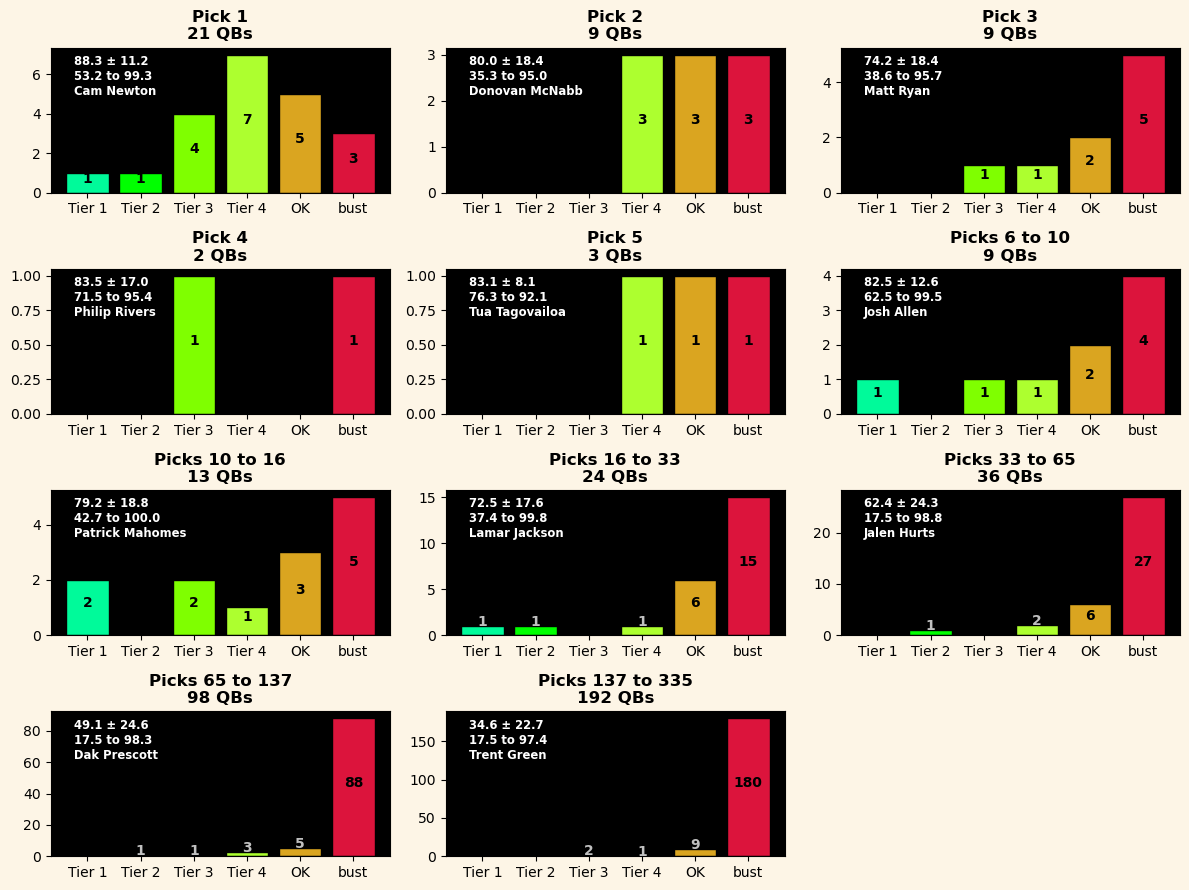

In [319]:
bar_x = np.linspace(0,5,6)
bar_c = ['mediumspringgreen','lime','chartreuse','greenyellow','goldenrod','crimson']
bar_l = ['Tier 1','Tier 2','Tier 3', 'Tier 4', 'OK', 'bust']


plt.figure(figsize=(12,9), layout='tight', facecolor='oldlace')

for i,ind in enumerate(g_data.index):
    plt.subplot(4,3,i+1, facecolor='k')
    # gather data, create and label bars
    bar_y = list(g_data.loc[ind,['t1','t2','t3','t4']].values.astype(int))
    bar_y.extend(list(np.array([g_data.loc[ind,'ok'], g_data.loc[ind,'busts']]).astype(int)))
    plt.bar(bar_x, bar_y, color=bar_c, tick_label=bar_l, ec='k')
    for i,val in enumerate(bar_y):
        if val ==0:
            continue
        if val < 0.1*np.max(bar_y):
            plt.text(bar_x[i], val, f'{val}', ha='center', fontweight='bold', color='silver')
        else:
            plt.text(bar_x[i], val/2, f'{val}', ha='center', fontweight='bold')
    
    # additional stats via text
    yb = plt.ylim()
    yb = np.abs(yb[1]-yb[0])
    best = g_data.loc[ind,"best"]
    best = ' '.join(best.split(' ')[0:2])
    plt.text(-.25,0.95*yb, 
 f'{g_data.loc[ind,"Avg"]:.1f} ± {g_data.loc[ind,"sd"]:.1f}\n{g_data.loc[ind,"Min"]:.1f} to {g_data.loc[ind,"Max"]:.1f}\n{best}', 
             color='white', fontsize='small', fontweight='bold', va='top')
    
    
    # title pick range
    if ind == g_data.index.max():
        ttext = f'Picks {ind} to {df.Pick.max()}'
    elif ind+1 in g_data.index:
        ttext = f'Pick {ind}'
    else:
        ttext = f'Picks {ind} to {g_data.index[list(g_data.index).index(ind)+1]}'
    plt.title(f'{ttext}\n{int(g_data.loc[ind,"total"])} QBs', fontweight='bold')

plt.savefig('graphs/performance_vs_pick.png', bbox_inches='tight')
plt.show()

**QB Draft Age**
  - pretty clear benefit to drafting younger QBs
  - next graph checks if drafting younger has been a developing trend
    - yes! prior to 2010, only 9 QBs were drafted at 21 years old out of 204 total (`4.4%`). 6 out of the 9 were in the top four tiers!
    - after 2010, 20 age 21 QBs were drafted out of 149 (`13.4%`)

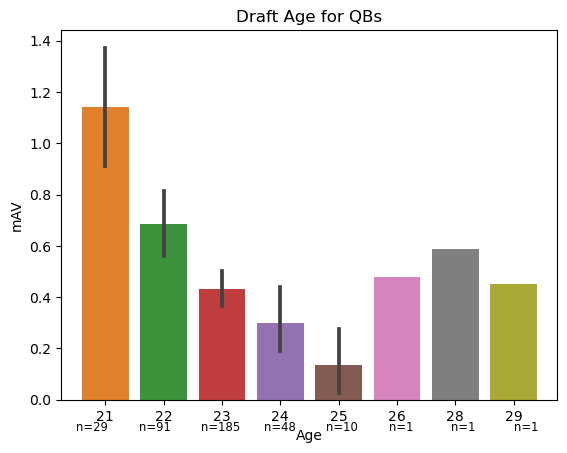

In [318]:
sns.barplot(df[df.Age>0], x=df.Age, y=df.mAV)

xb = (0.25,8.75)
x_text =np.linspace(.5,8, 8)
plt.xlim(xb)
for i,count in enumerate(df.value_counts('Age').sort_index().iloc[1:].values):
    plt.text(x_text[i], -0.12, f'n={count}', fontsize='small')
plt.title('Draft Age for QBs')
plt.savefig('graphs/performance_vs_age.png', bbox_inches='tight')
plt.show()

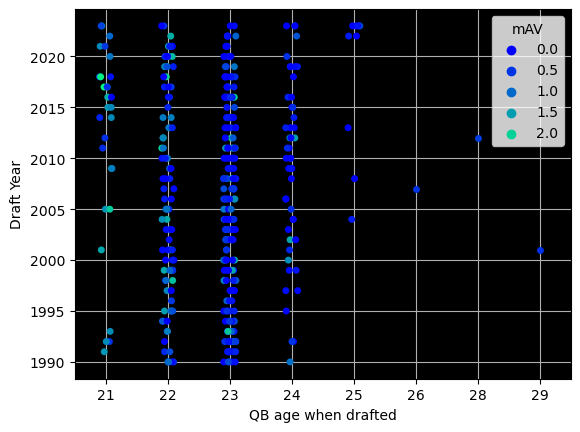

In [317]:
#plt.figure(figsize=(16,4))
ax = sns.stripplot(df[df.Age>0], x='Age', y='draft_year', hue='mAV', palette='winter')
ax.set_facecolor('k')
ax.set_ylabel('Draft Year')
ax.set_xlabel('QB age when drafted')
ax.grid()
plt.savefig('graphs/age-draft_year.png', bbox_inches='tight')
plt.show()

In [287]:
df[(df.Age<22)&(df.Age>0)&(df.draft_year<2010)].sort_values('mAV',ascending=False)

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,Yrs_Starter,...,Att,Yds,TD,Int,Rushing_Att,Rushing_Yds,Rushing_TD,Uni,draft_year,mAV
3985,1,24,GNB,Aaron Rodgers,QB,21,2023,4,10,14,...,7661,59055,475,105,719,3466,35,California,2005,1.937623
2938,1,1,ATL,Michael Vick,QB,21,2015,0,4,7,...,3217,22464,133,88,873,6109,36,Virginia Tech,2001,1.567391
4979,1,1,DET,Matthew Stafford,QB,21,2023,0,2,13,...,7649,56047,357,180,411,1315,15,Georgia,2009,1.518026
363,2,33,ATL,Brett Favre HOF,QB,21,2010,3,11,19,...,10169,71838,508,336,602,1844,14,Southern Miss,1991,1.430589
3962,1,1,SFO,Alex Smith,QB,21,2020,0,3,14,...,5193,35650,199,109,580,2604,15,Utah,2005,1.393024
1001,1,1,NWE,Drew Bledsoe,QB,21,2006,0,4,12,...,6717,44611,251,206,385,764,10,Washington St.,1993,1.358849
830,6,166,NYJ,Jeff Blake,QB,21,2005,0,1,8,...,3241,21711,134,99,418,2027,14,East Carolina,1992,1.329945
4995,1,17,TAM,Josh Freeman,QB,21,2015,0,0,4,...,2048,13873,81,68,205,946,4,Kansas St.,2009,1.190316
689,1,25,DEN,Tommy Maddox,QB,21,2005,0,0,2,...,1200,8087,48,54,68,128,1,UCLA,1992,0.482087


In [288]:
cutoffs

array([1.35777099, 1.61738569, 1.92348465, 1.95864348])

**School, Team based groupings**
 - do certain schools produce more/better quarterbacks than others?
   - some have definitely sent more to be drafted, but no clear performance trends
   - adding draft_year as a dimension could be useful to capture snapshots of "eras"/coaching systems in college that may have translated well to the NFL
 - have certain NFL teams had more/less success at drafting quarterbacks?
   - *teams that moved cities/changed names were **not** grouped back together*
   - over a long period of time, most teams have drafted about the same number of QBs.
   - hitting on a great QB is much more important than getting consistently decent QBs
     - `KAN` is in the bottom statistically, but they got Mahommes recently

In [67]:
uni_list = df.value_counts('Uni')>3
uni_list = uni_list[uni_list==True]
uni_list = uni_list.index.values

In [68]:
uni_list

array(['USC', 'LSU', 'Ohio St.', 'Florida St.', 'Oregon', 'Washington',
       'Michigan', 'Tennessee', 'Stanford', 'Georgia', 'California',
       'Louisville', 'Alabama', 'Florida', 'Texas A&M', 'Fresno St.',
       'Oklahoma', 'Miami (FL)', 'Notre Dame', 'Michigan St.', 'BYU',
       'Penn St.', 'UCLA', 'Washington St.', 'Houston', 'Virginia Tech',
       'West Virginia', 'Pittsburgh', 'Purdue', 'Iowa', 'Kansas St.',
       'North Carolina St.', 'Clemson', 'Auburn', 'Texas', 'Boston Col.',
       'Virginia', 'Oregon St.', 'Arizona St.'], dtype=object)

In [69]:
uni_rank = pd.Series(index=uni_list)
for ind in uni_rank.index:
    uni_rank[ind] = df[df.Uni==ind].mAV.mean()
    
team_rank = pd.Series(index=df.Tm.unique())
for ind in team_rank.index:
    team_rank[ind] = df[df.Tm==ind].mAV.mean()
team_rank = team_rank[team_rank>0]

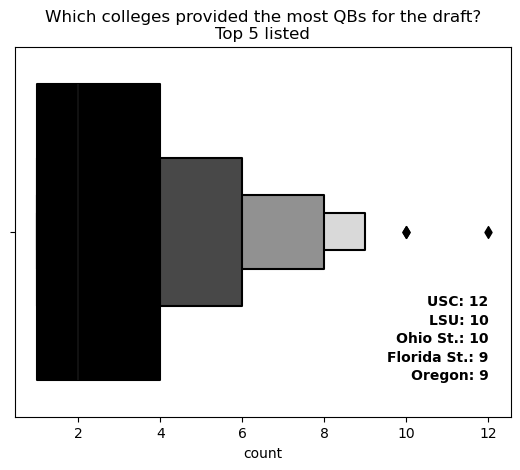

In [316]:
sns.boxenplot(x=df.value_counts('Uni'), color='k')
top = df.value_counts('Uni').head()
for i,ind in enumerate(top.index):
    plt.text(12,.2+.05*i, f'{ind}: {top[ind]}', ha='right', fontweight='bold')
plt.title("Which colleges provided the most QBs for the draft?\nTop 5 listed")
plt.savefig('graphs/college_qb_count.png', bbox_inches='tight')
plt.show()

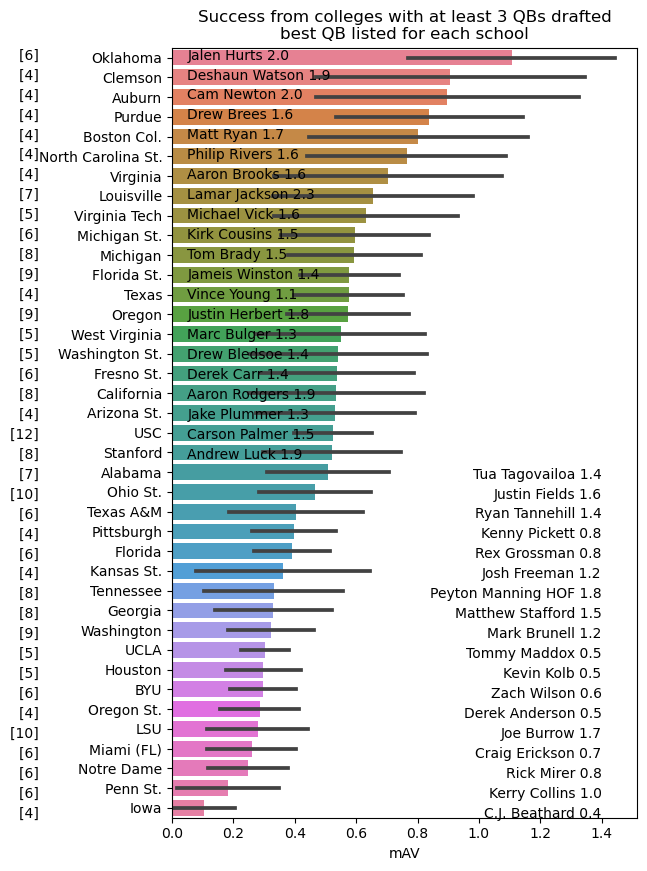

In [314]:
plt.figure(figsize=(6,10))
sns.barplot(df[df.Uni.isin(uni_list)], y='Uni', x='mAV',
            errorbar='se', order=uni_rank.sort_values(ascending=False).index,
            palette='husl')
plt.ylabel("")
plt.title('Success from colleges with at least 3 QBs drafted\nbest QB listed for each school')

yb = plt.ylim()
y_text = np.linspace(yb[0],yb[1]+.6,uni_rank.shape[0])
for i,uni in enumerate(uni_rank.sort_values(ascending=True).index):
    if i>17:
        x_text = .05
        ha = 'left'
    else:
        x_text = 1.4
        ha = 'right'
    plt.text(x_text, y_text[i],  
 f"{df[df.Uni==uni].sort_values('mAV', ascending=False).iloc[0,3]} {df[df.Uni==uni].sort_values('mAV', ascending=False).iloc[0,-1]:.1f}",
             ha=ha)
    plt.text(-0.42, y_text[i], f"[{df[df.Uni==uni].shape[0]}] ",
             ha='right')
plt.savefig('graphs/college_qb_rank.png', bbox_inches='tight')
plt.show()

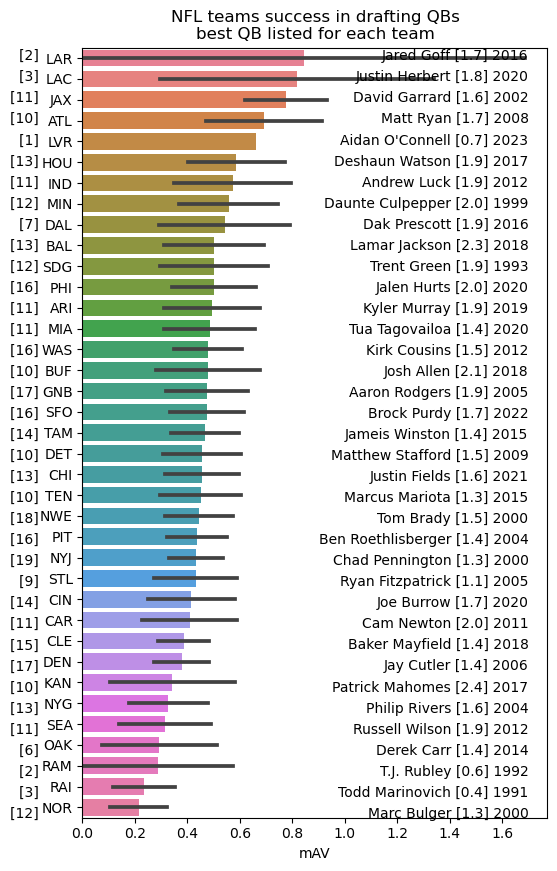

In [315]:
plt.figure(figsize=(6,10))
sns.barplot(df[df.Tm!='PHO'], y='Tm', x='mAV',
            errorbar='se', order=team_rank.sort_values(ascending=False).index,
           palette='husl')
plt.ylabel("Team", fontweight='bold')
plt.title('NFL teams success in drafting QBs\nbest QB listed for each team')

yb = plt.ylim()
y_text = np.linspace(yb[0],yb[1]+.6,team_rank.shape[0])
for i,team in enumerate(team_rank.sort_values(ascending=True).index):
    x_text = 1.7
    ha = 'right'
    plt.text(x_text, y_text[i],  
 f"{df[df.Tm==team].sort_values('mAV', ascending=False).iloc[0,3]} [{df[df.Tm==team].sort_values('mAV', ascending=False).iloc[0,-1]:.1f}] {df[df.Tm==team].sort_values('mAV', ascending=False).iloc[0,-2]}",
             ha=ha,)
    plt.text(-0.15, y_text[i], f"[{df[df.Tm==team].shape[0]}] ",
             ha='right')
plt.ylabel('')
plt.savefig('graphs/team_qb_rank.png', bbox_inches='tight')
plt.show()

---
#### Other Stuff

<Axes: xlabel='Pick', ylabel='mAV'>

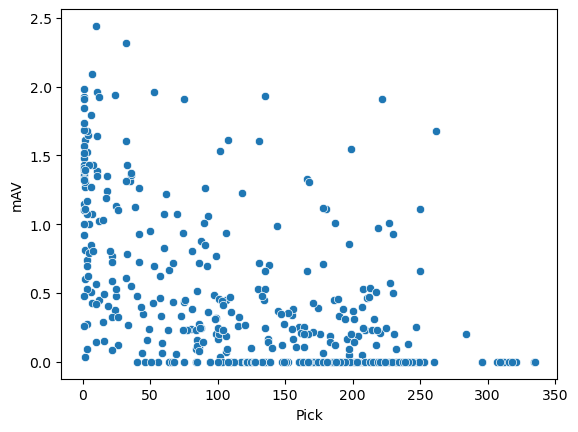

In [250]:
sns.scatterplot(df, x=df.Pick, y=df.mAV)

In [9]:
g_data = pd.DataFrame()

for i in range(len(pick_tiers)-1):
    pmin = pick_tiers[i]
    pmax = pick_tiers[i+1]
    sub = df[df.Pick.between(pmin,pmax, inclusive='left')]
    scores = pd.Series(percentileofscore(df.wAV,sub.wAV))
    best = sub[sub.wAV == sub.wAV.max()]
    
    g_data.loc[pmin, 'Avg'] = scores.mean()
    g_data.loc[pmin, 'sd'] = scores.std()
    g_data.loc[pmin, 'Min'] = scores.min()
    g_data.loc[pmin, 'Max'] = scores.max()
    g_data.loc[pmin, 'best'] = f"{best.Player.values[0].replace(' HOF','')} {best.draft_year.values[0]} {best.Tm.values[0]} ({percentileofscore(df.wAV, best.wAV)[0]:.1f})"
    g_data.loc[pmin, 'total'] = sub.shape[0]
    g_data.loc[pmin, 'busts'] = np.sum(scores<80)
    g_data.loc[pmin, 't1'] = scores.between(99,100).sum()
    g_data.loc[pmin, 't2'] = scores.between(98,99, inclusive='left').sum()
    g_data.loc[pmin, 't3'] = scores.between(95,98, inclusive='left').sum()
    g_data.loc[pmin, 't4'] = scores.between(90,95, inclusive='left').sum()
    g_data.loc[pmin, 'ok'] = scores.between(80,90, inclusive='left').sum()

In [10]:
g_data.round(1)

,Avg,sd,Min,Max,best,total,busts,t1,t2,t3,t4,ok
1,87.9,11.3,59.4,99.8,Peyton Manning 1998 IND (99.8),21.0,3.0,1.0,0.0,6.0,4.0,7.0
2,77.3,16.6,39.3,97.0,Donovan McNabb 1999 PHI (97.0),9.0,4.0,0.0,0.0,1.0,0.0,4.0
3,74.9,18.3,46.4,98.6,Matt Ryan 2008 ATL (98.6),9.0,6.0,0.0,1.0,1.0,0.0,1.0
4,74.5,34.4,50.1,98.8,Philip Rivers 2004 NYG (98.8),2.0,1.0,0.0,1.0,0.0,0.0,0.0
5,84.5,6.9,79.3,92.3,Kerry Collins 1995 CAR (92.3),3.0,1.0,0.0,0.0,0.0,1.0,1.0
6,79.6,12.4,56.5,94.2,Ryan Tannehill 2012 MIA (94.2),9.0,4.0,0.0,0.0,0.0,2.0,3.0
10,77.9,15.8,50.1,98.1,Ben Roethlisberger 2004 PIT (98.1),13.0,7.0,0.0,1.0,1.0,2.0,2.0
16,72.1,17.7,39.3,99.5,Drew Brees 2001 SDG (99.5),24.0,16.0,2.0,0.0,1.0,1.0,4.0
33,63.8,24.0,17.5,99.0,Brett Favre 1991 ATL (99.0),36.0,25.0,1.0,0.0,0.0,3.0,7.0
65,49.8,25.1,17.5,98.3,Russell Wilson 2012 SEA (98.3),98.0,85.0,0.0,1.0,2.0,3.0,7.0


In [232]:
for i in range(len(pick_tiers)-1):
    pmin = pick_tiers[i]
    pmax = pick_tiers[i+1]
    sub = df[df.Pick.between(pmin,pmax, inclusive='left')]
    scores = percentileofscore(df.wAV,sub.wAV)
    best = sub[sub.wAV == sub.wAV.max()]
    if pmax == pmin+1:
        print(f'\twith pick {pmin}\t[{sub.shape[0]} QBs since 1990]')
    else:
        print(f'\tbetween picks {pmin} and {pmax}\t[{sub.shape[0]} QBs since 1990]')
    
    # Avg, Median performance
    print(f'{scores.mean():.1f} ± {scores.std():.2f}\tPerformance Percentile')
    print(f'{scores.min():.1f} to {scores.max():.1f}')
    # some kind of probability
    # busts (<90th percentile)
    print(f'{round(100*np.sum(scores<80)/sub.shape[0])}% busts \t<80th percentile')
    # best pick(s)
    print('\t\tbest pick')
    print(f'{best.Player.values[0]} {best.draft_year.values[0]} {best.Tm.values[0]}')
    print(f'{percentileofscore(df.wAV, best.wAV)[0]:.1f}th percentile')
    print()

	with pick 1	[21 QBs since 1990]
87.9 ± 11.02	Performance Percentile
59.4 to 99.8
14% busts 	<80th percentile
		best pick
Peyton Manning HOF 1998 IND
99.8th percentile

	with pick 2	[9 QBs since 1990]
77.3 ± 15.69	Performance Percentile
39.3 to 97.0
44% busts 	<80th percentile
		best pick
Donovan McNabb 1999 PHI
97.0th percentile

	with pick 3	[9 QBs since 1990]
74.9 ± 17.23	Performance Percentile
46.4 to 98.6
67% busts 	<80th percentile
		best pick
Matt Ryan 2008 ATL
98.6th percentile

	with pick 4	[2 QBs since 1990]
74.5 ± 24.34	Performance Percentile
50.1 to 98.8
50% busts 	<80th percentile
		best pick
Philip Rivers 2004 NYG
98.8th percentile

	with pick 5	[3 QBs since 1990]
84.5 ± 5.62	Performance Percentile
79.3 to 92.3
33% busts 	<80th percentile
		best pick
Kerry Collins 1995 CAR
92.3th percentile

	between picks 6 and 10	[9 QBs since 1990]
79.6 ± 11.67	Performance Percentile
56.5 to 94.2
44% busts 	<80th percentile
		best pick
Ryan Tannehill 2012 MIA
94.2th percentile

	between